 #### Example emulator for a simple equation

This notebook roughly follows: https://hackmd.io/0jpLEK5qQam7jcJ_-nPIlQ?both

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt

The equation to be modelled is:

$ f(\theta,x) = \theta_J \times sin(x) + cos(x) + \epsilon$

Where $\epsilon$ is added noise such that:

$\epsilon = N(0,0.05)$

#### Create Training data

In [3]:
# Training data is 100 points in [0,1] inclusive regularly spaced
x_0 = 0
x_end = 10
num_trials = 100
x = np.linspace(x_0, x_end, num_trials)


J = 20 # number of input parameters
theta = np.linspace(0, 10, J)


S =[i * np.sin(x) + 5*np.cos(x) + np.random.randn(np.size(x)) * np.sqrt(0.05) for i in theta]

S =[i * np.sin(x) + 1/(i+1) * np.cos(-x) + x**(1/(i+1)) + np.random.randn(np.size(x)) * np.sqrt(0.05) for i in theta]



#Putting S in the form NxJ
S = np.array(S).T


print("S has shape:", S.shape)


S has shape: (100, 20)


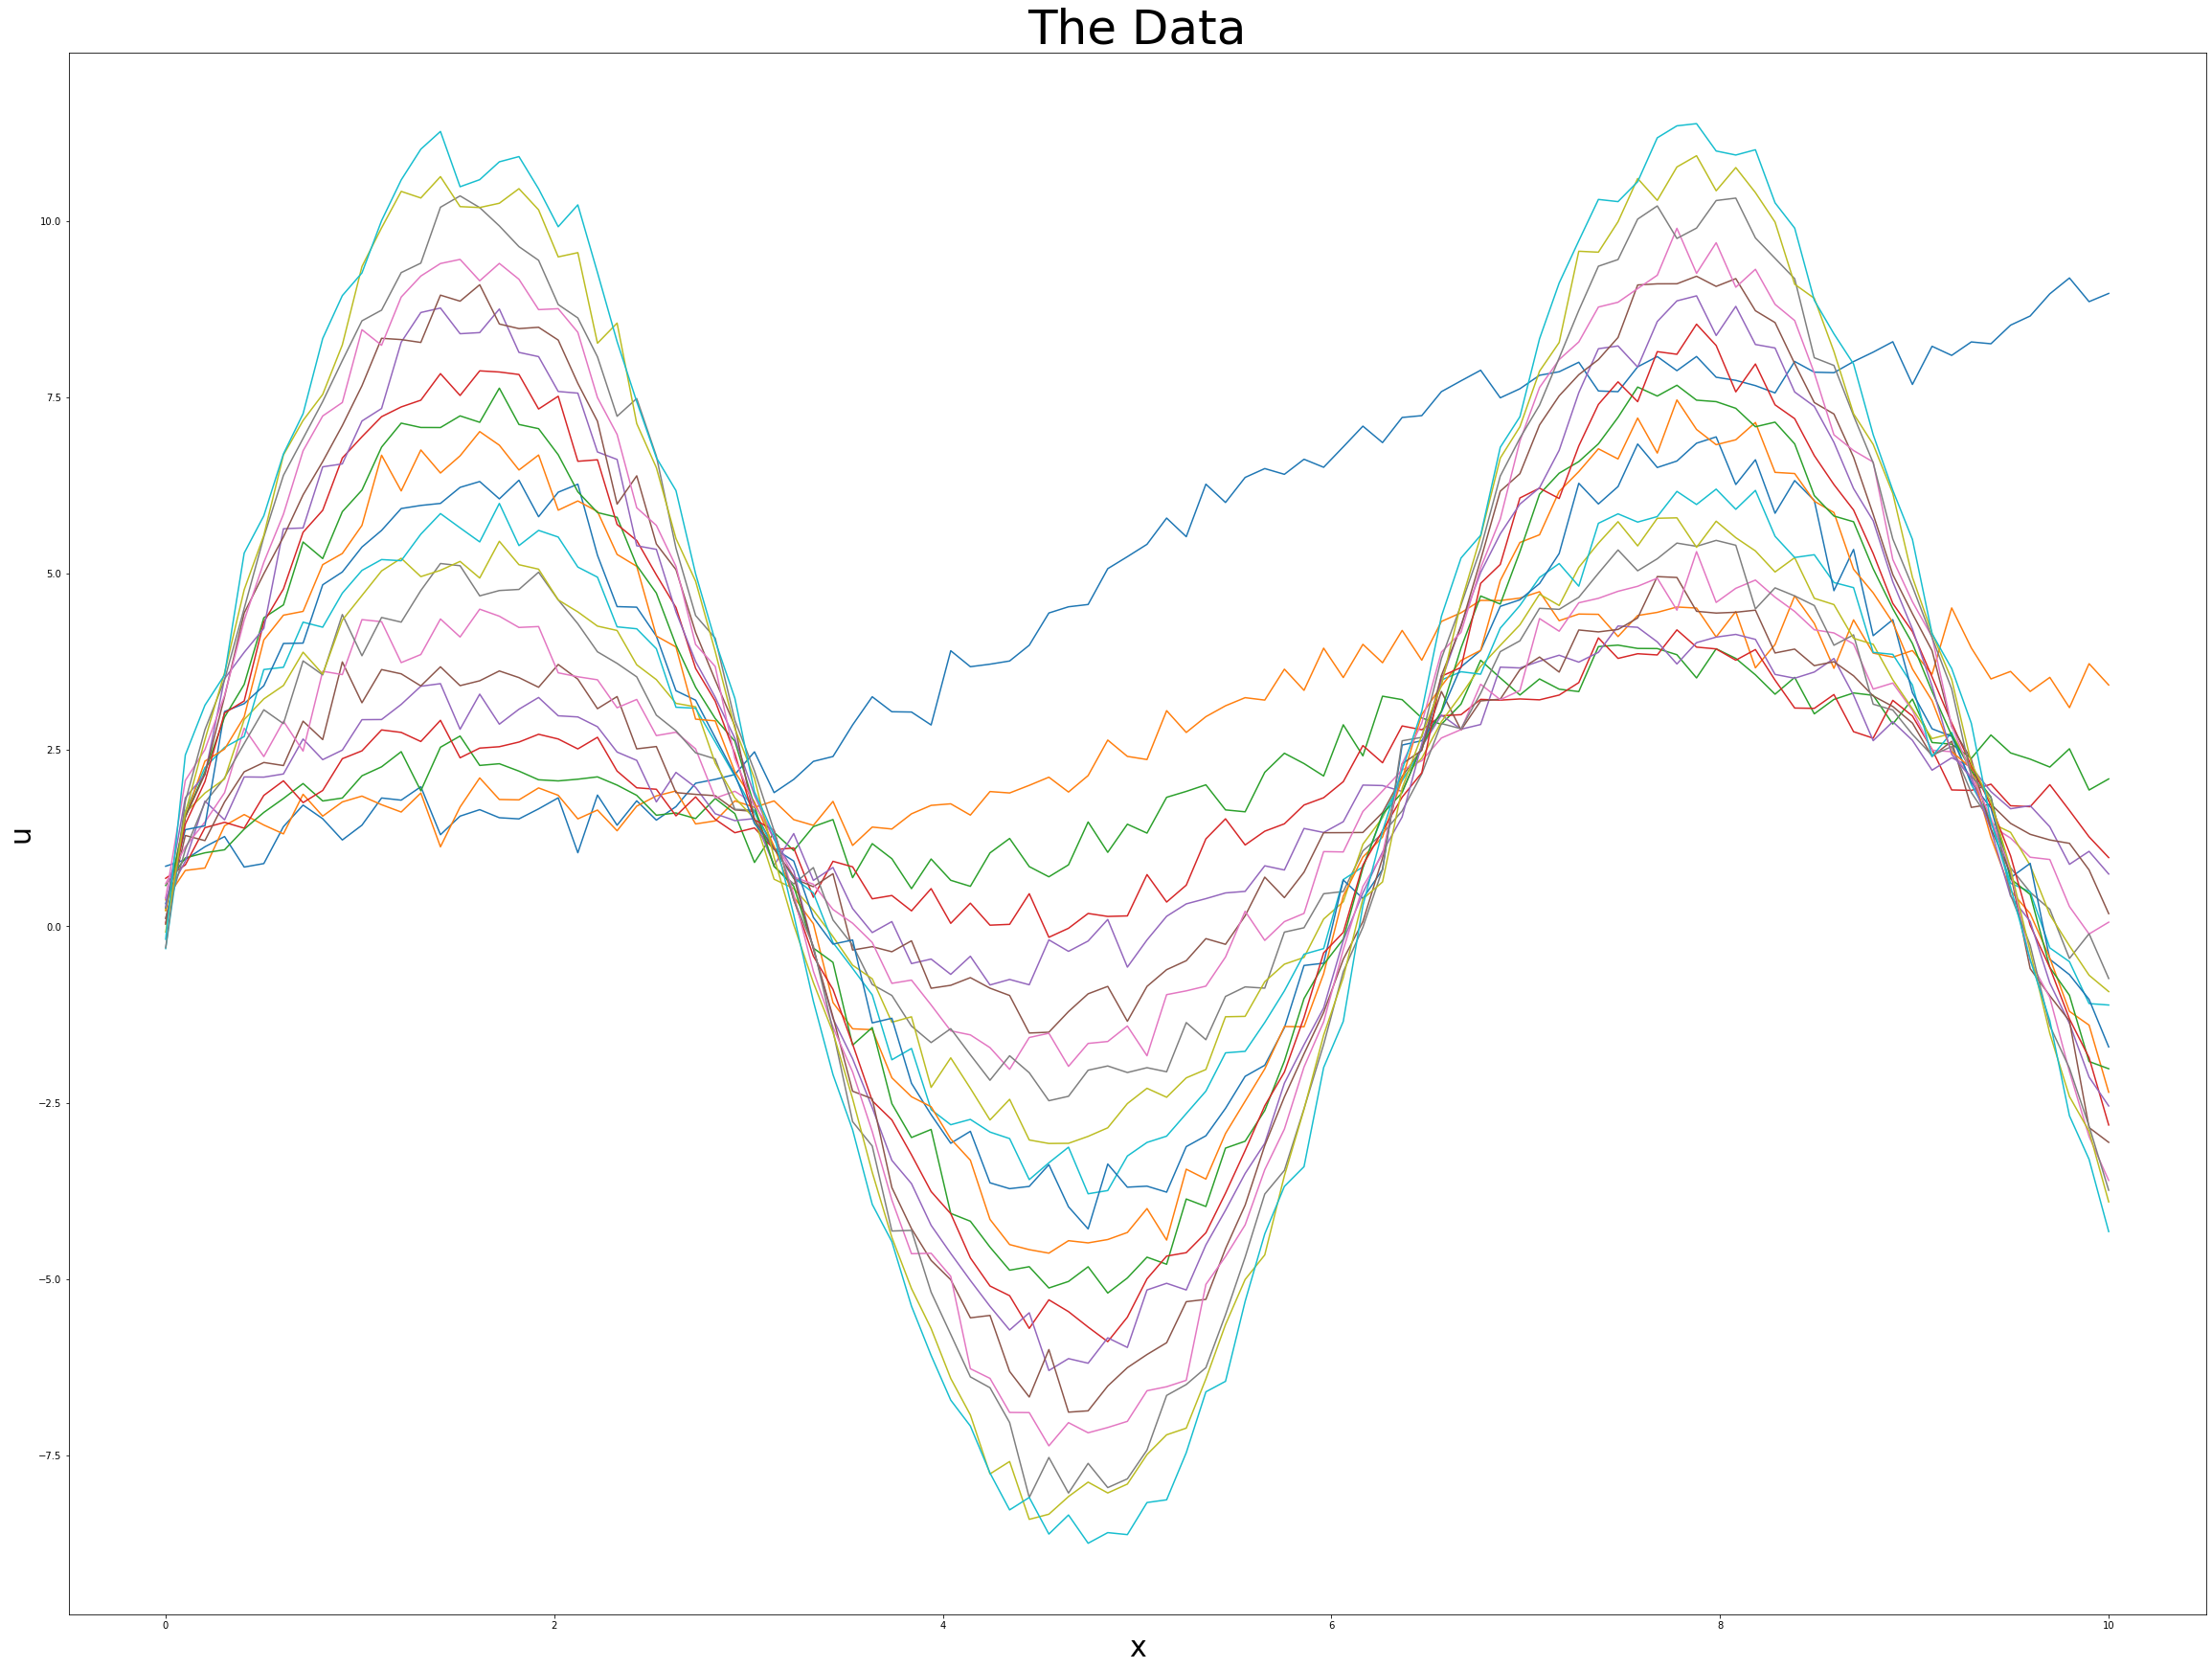

In [4]:
f, ax = plt.subplots(1, 1, figsize=(40, 30))
ax.set_title('The Data', fontsize = 50)
ax.set_xlabel('x', fontsize = 30)
ax.set_ylabel('u', fontsize = 30)



for i in range(len(theta)):
    ax.plot(x, S[:,i])

#### Performing principle componant analysis

In [5]:
# Standardise the data:
S_avg = np.mean(S, axis=1) #Compute mean for each column and create the average matrix

B = S - np.tile(S_avg, (J,1)).T # Centre mean around 0
B = B / np.std(B) # Variance of 1

'''
Question:
Is it neccessary to alter the variance to 1?
'''

print("Mean:", np.mean(B), "\n"
      "Variance:", np.var(B))


Mean: 8.881784197001253e-18 
Variance: 0.9999999999999998


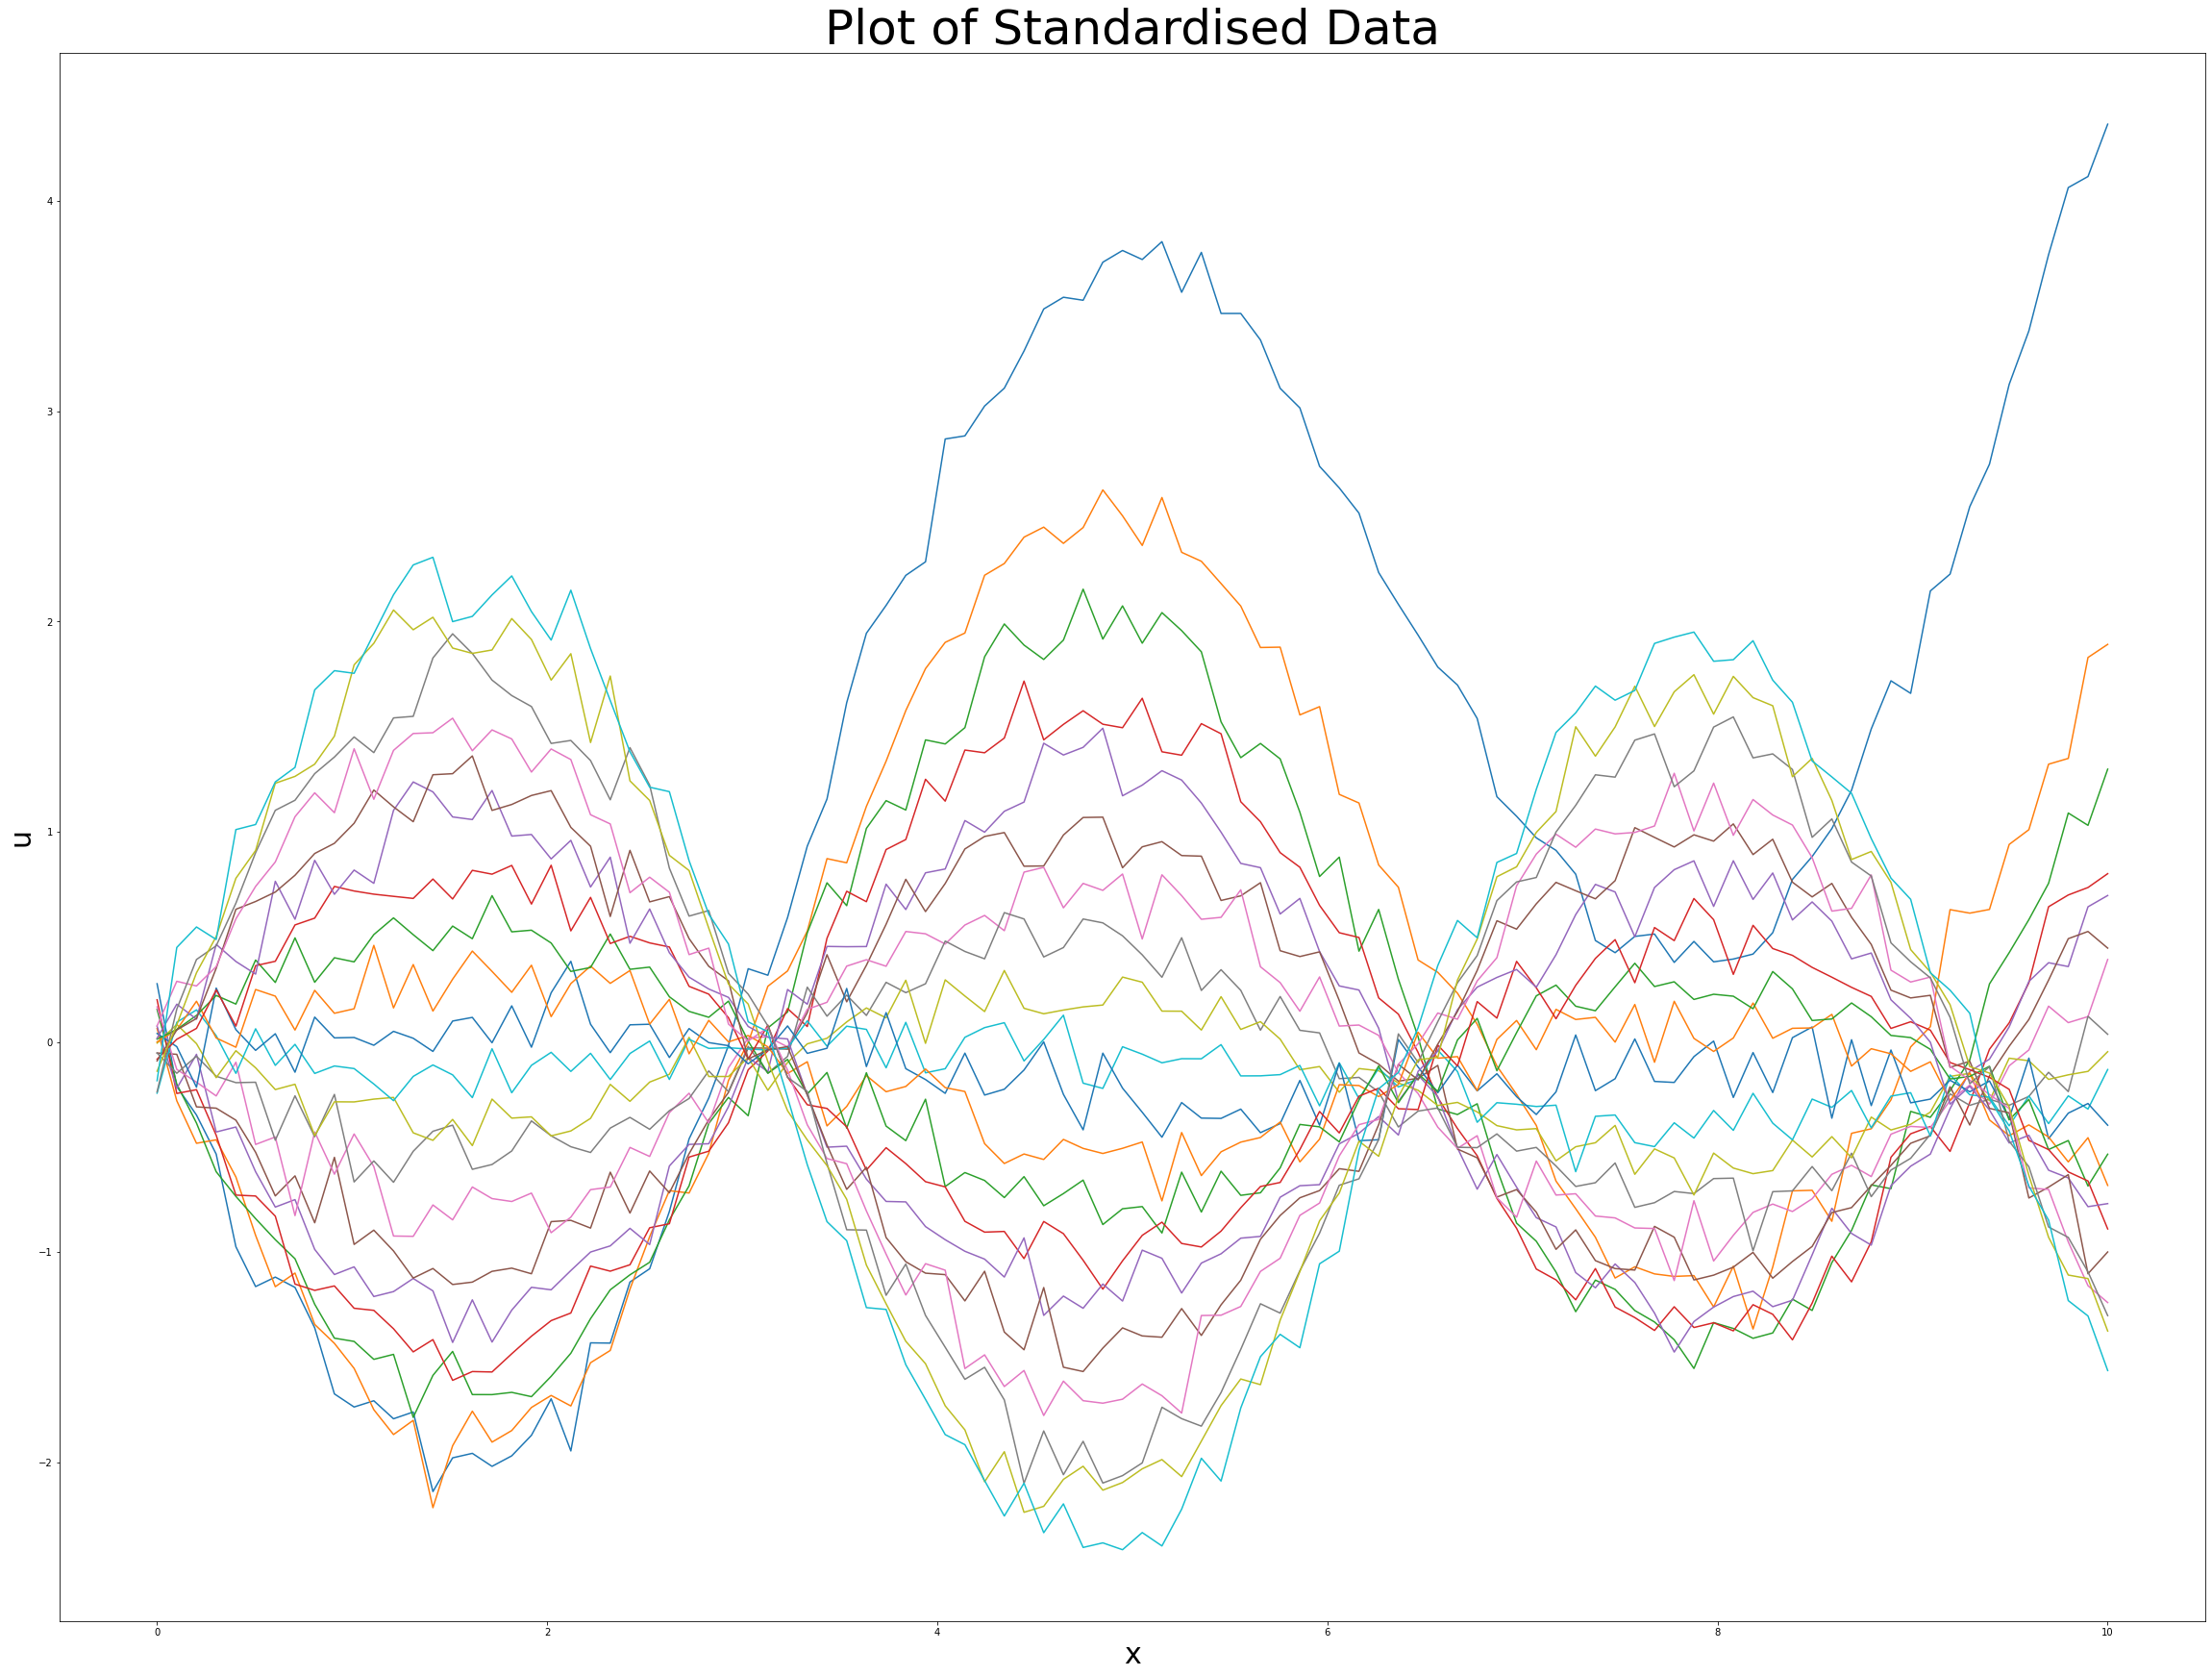

In [6]:
f, ax = plt.subplots(1, 1, figsize=(40, 30))
ax.set_title('Plot of Standardised Data', fontsize = 50)
ax.set_xlabel('x', fontsize = 30)
ax.set_ylabel('u', fontsize = 30)



for i in range(len(theta)):
    ax.plot(x, B[:,i])

SVD is performed ( B = U @ np.diag(D) @ VT )

In [7]:
U, D, VT = np.linalg.svd(B,full_matrices=0)

principal_componant = U @ np.diag(D)
VT.shape


(20, 20)

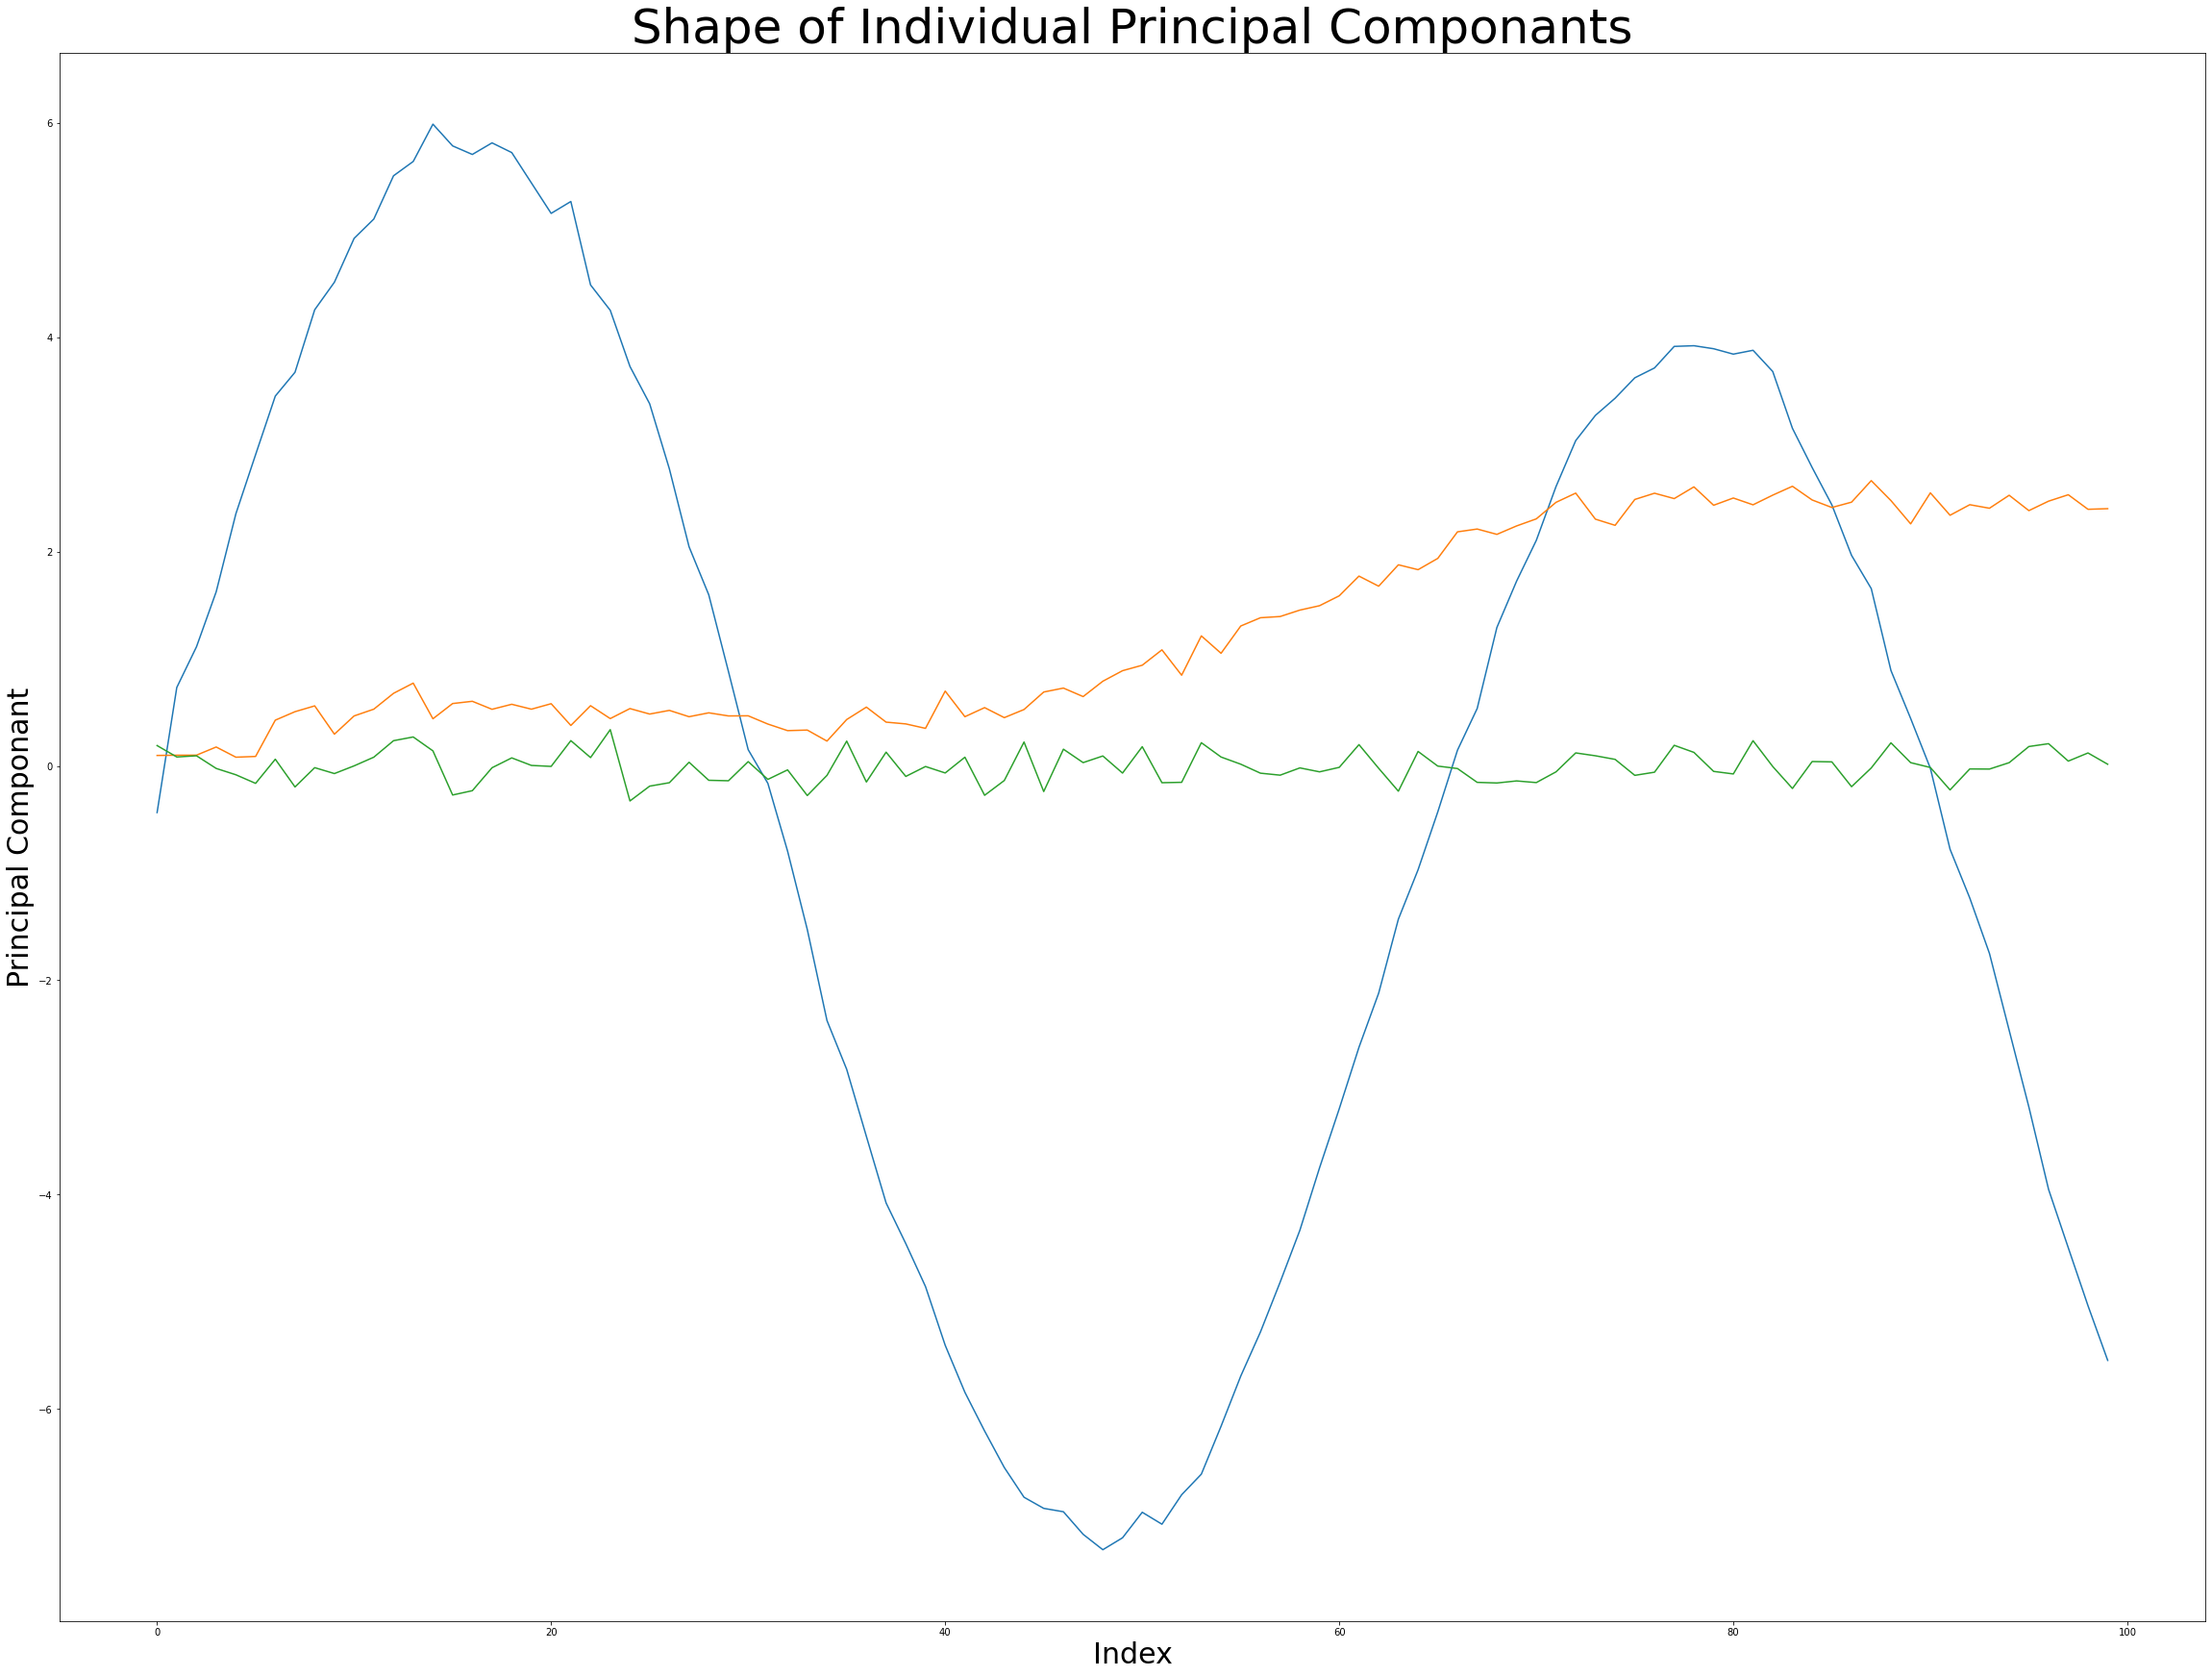

In [8]:
f, ax = plt.subplots(1, 1, figsize=(40, 30))
    
ax.set_title('Shape of Individual Principal Componants', fontsize = 50)
ax.set_xlabel('Index', fontsize = 30)
ax.set_ylabel('Principal Componant', fontsize = 30)
    
    
for i in range(3):  
    ax.plot(range(len(principal_componant)) , principal_componant[:,i])


Text(0, 0.5, 'PC2')

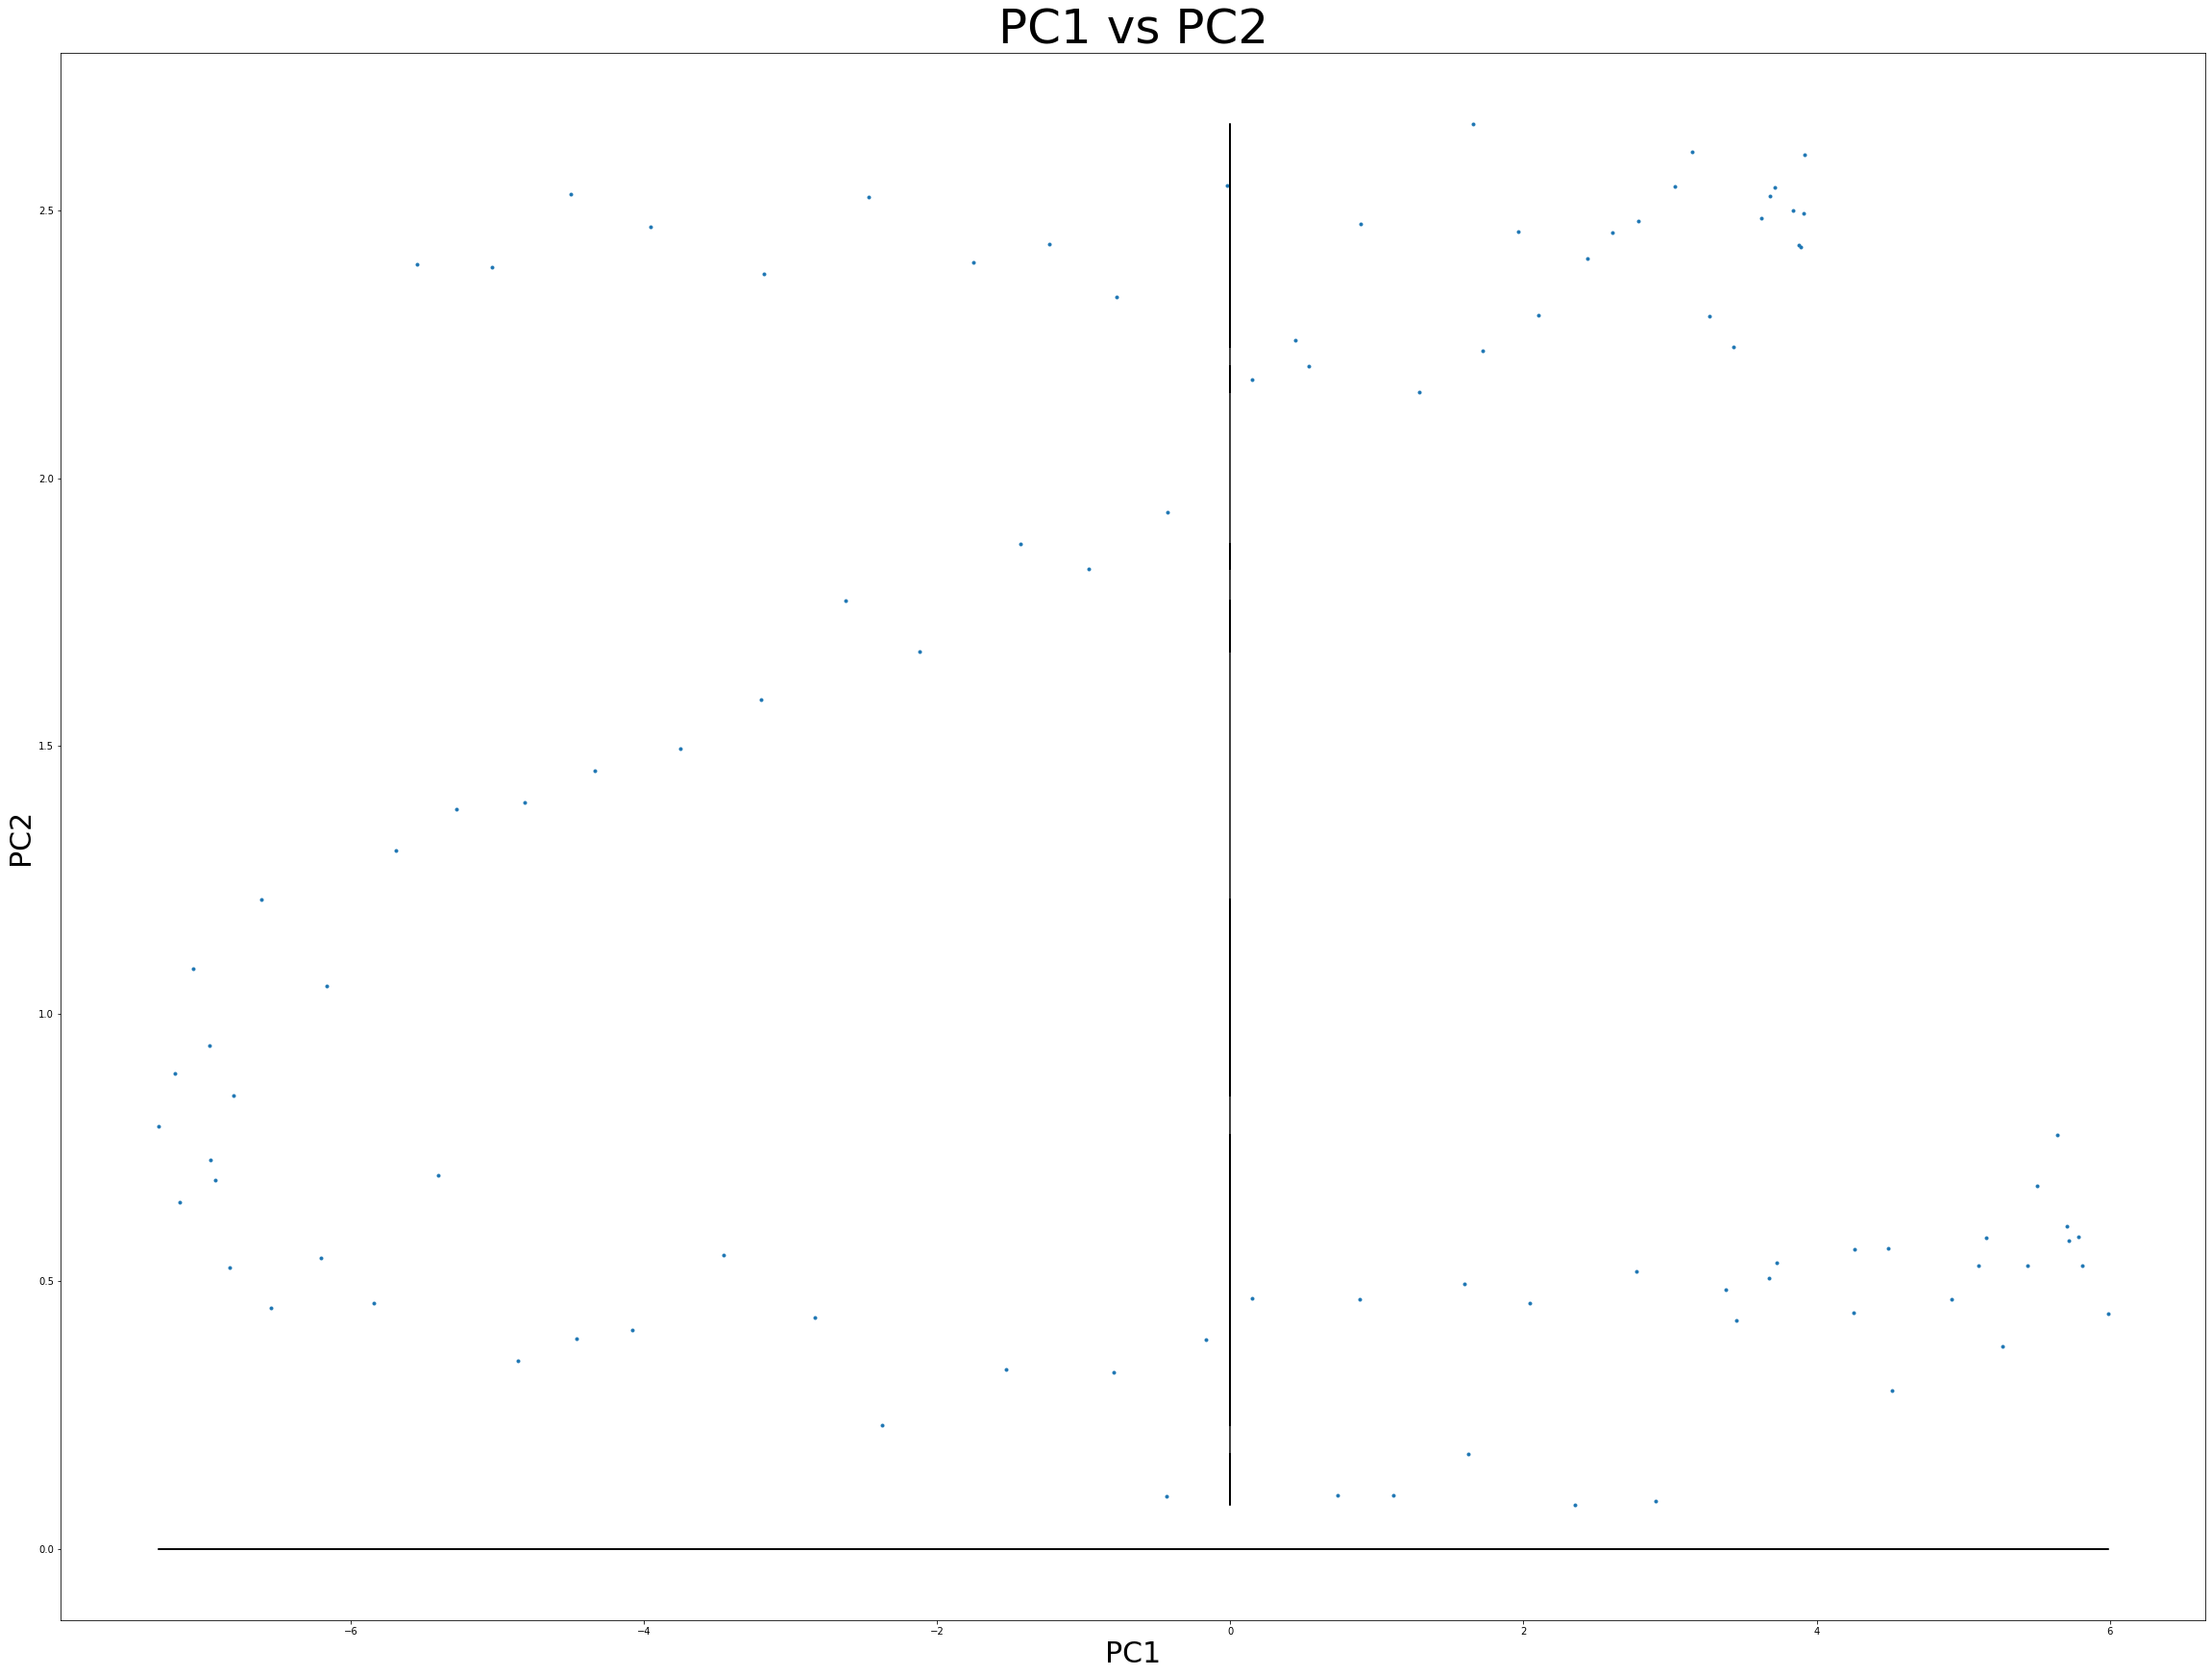

In [9]:
f, ax = plt.subplots(1, 1, figsize=(40, 30))

    
ax.plot(principal_componant[:,0] , principal_componant[:,1],'.')
ax.plot(principal_componant[:,0], 0* principal_componant[:,0], 'k')
ax.plot(0*principal_componant[:,0], principal_componant[:,1], 'k')

ax.set_title('PC1 vs PC2', fontsize = 50)
ax.set_xlabel('PC1', fontsize = 30)
ax.set_ylabel('PC2', fontsize = 30)

#### Setting up the model

In [10]:
import torch
import gpytorch
"""
gpytorch.models.ExactGP
gpytorch.likelihoods.GaussianLikelihood
gpytorch.means.ZeroMean
gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
gpytorch.distributions.MultivariateNormal
"""

'\ngpytorch.models.ExactGP\ngpytorch.likelihoods.GaussianLikelihood\ngpytorch.means.ZeroMean\ngpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())\ngpytorch.distributions.MultivariateNormal\n'

In [11]:
#Setting the model up

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        base_covar_module = gpytorch.kernels.MaternKernel(nu=1.5)
        self.covar_module = gpytorch.kernels.ScaleKernel(base_covar_module)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
# initialize likelihood and model
#likelihood = gpytorch.likelihoods.GaussianLikelihood()
#model = ExactGPModel(train_x, train_y, likelihood)

In [12]:
# Running training loop to train M seperate models.
training_iter = 10000

# Training data:
M = 2 #number of principal components to use

train_x = torch.tensor(theta)
train_y = torch.tensor( principal_componant[: , 0:M].T @ B) # Using first 2 principal componants


# Training loop:
model = []
likelihood = []
for i in range(M):
    likelihood.append(gpytorch.likelihoods.GaussianLikelihood())
    model.append(ExactGPModel(train_x, train_y[i], likelihood[i]))

for M in range(len(model)):
    # Find optimal model hyperparameters
    model[M].train()
    likelihood[M].train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
    {'params': model[M].parameters()}, # Includes GaussianLikelihood parameters
    ], lr=0.5)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood[M], model[M])
    model[M] = model[M].double()

    for i in range(training_iter+1):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model[M](train_x.double())
        # Calc loss and backprop gradients
        loss = -mll(output, train_y[M])
        loss.backward()
        if i % 1000 == 0:
            print('Model %i - Iter %d/%d - Loss: %.3f lengthscale: %.3f noise: %.3f' % (
                M+1, i , training_iter, loss.item(),
                model[M].covar_module.base_kernel.lengthscale.item(),
                model[M].likelihood.noise.item()
            ))
        optimizer.step()

Model 1 - Iter 0/10000 - Loss: 31887.465 lengthscale: 0.693 noise: 0.693
Model 1 - Iter 1000/10000 - Loss: 537.494 lengthscale: 2.849 noise: 24.823
Model 1 - Iter 2000/10000 - Loss: 360.796 lengthscale: 2.849 noise: 36.966
Model 1 - Iter 3000/10000 - Loss: 276.074 lengthscale: 2.849 noise: 48.376
Model 1 - Iter 4000/10000 - Loss: 222.037 lengthscale: 2.849 noise: 60.277
Model 1 - Iter 5000/10000 - Loss: 182.984 lengthscale: 2.849 noise: 73.342
Model 1 - Iter 6000/10000 - Loss: 152.840 lengthscale: 2.850 noise: 88.105
Model 1 - Iter 7000/10000 - Loss: 128.692 lengthscale: 2.850 noise: 105.070
Model 1 - Iter 8000/10000 - Loss: 108.922 lengthscale: 2.851 noise: 124.763
Model 1 - Iter 9000/10000 - Loss: 92.529 lengthscale: 2.851 noise: 147.754
Model 1 - Iter 10000/10000 - Loss: 78.833 lengthscale: 2.852 noise: 174.685
Model 2 - Iter 0/10000 - Loss: 1005.191 lengthscale: 0.693 noise: 0.693
Model 2 - Iter 1000/10000 - Loss: 26.045 lengthscale: 0.589 noise: 29.711
Model 2 - Iter 2000/10000 - 

In [13]:
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 10, 200) # Same start and finish as training data but with higher sampling
    test_x = test_x.double()
    
    observed_pred = []
    for i in range(len(model)):
        # Get into evaluation (predictive posterior) mode
        model[i].eval()
        likelihood[i].eval()
        
        observed_pred.append( likelihood[i](model[i](test_x)) )

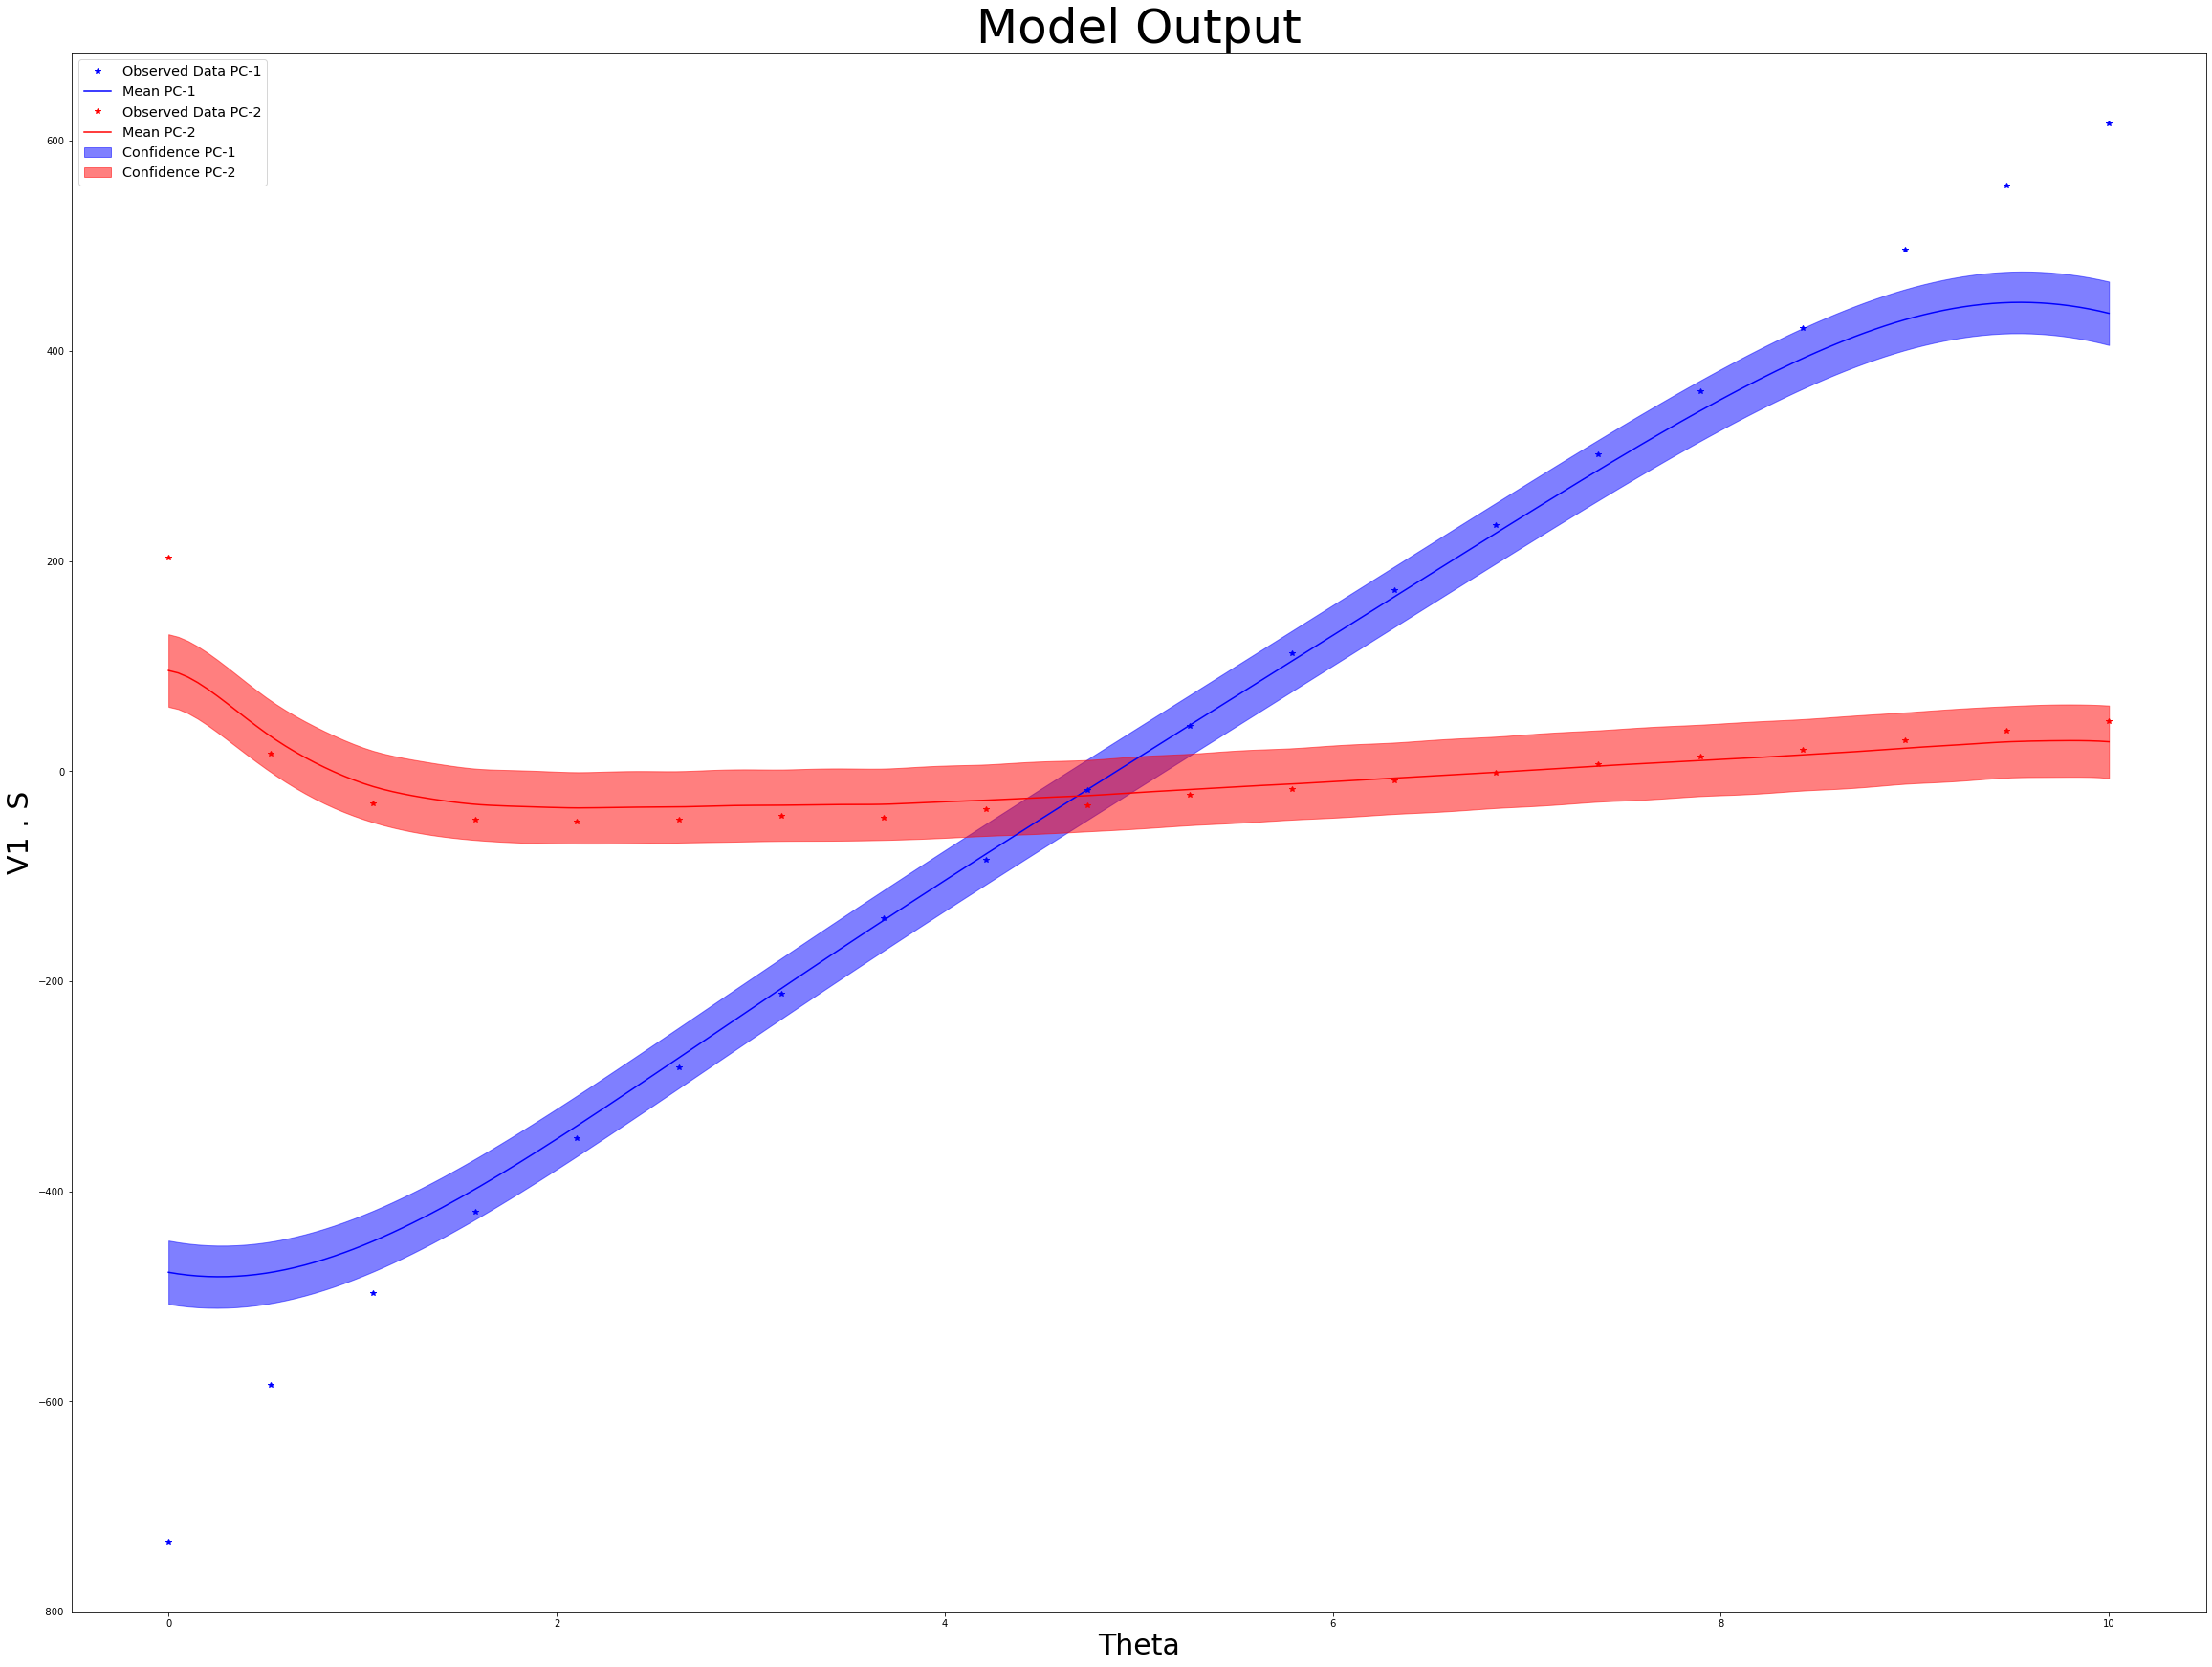

In [14]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(40, 30))
    import numpy
    
    colour = ['b', 'r', 'g', 'c', 'y']
    
    for i in range(len(observed_pred)):
        # Plot training data as black stars
        pc = ' PC-' + str(i+1)
        ax.plot(train_x.numpy(), train_y[i].numpy(), colour[i] + '*', label='Observed Data' + pc)

        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred[i].mean.numpy(), colour[i] + '-', label='Mean' + pc)

        # Get upper and lower confidence bounds
        lower, upper = observed_pred[i].confidence_region()

        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, color=colour[i],
                        label='Confidence' + pc)
    
    
    
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.legend(fontsize='x-large')
    ax.set_title('Model Output', fontsize = 50)
    ax.set_xlabel('Theta', fontsize = 30)
    ax.set_ylabel('V1 . S', fontsize = 30)


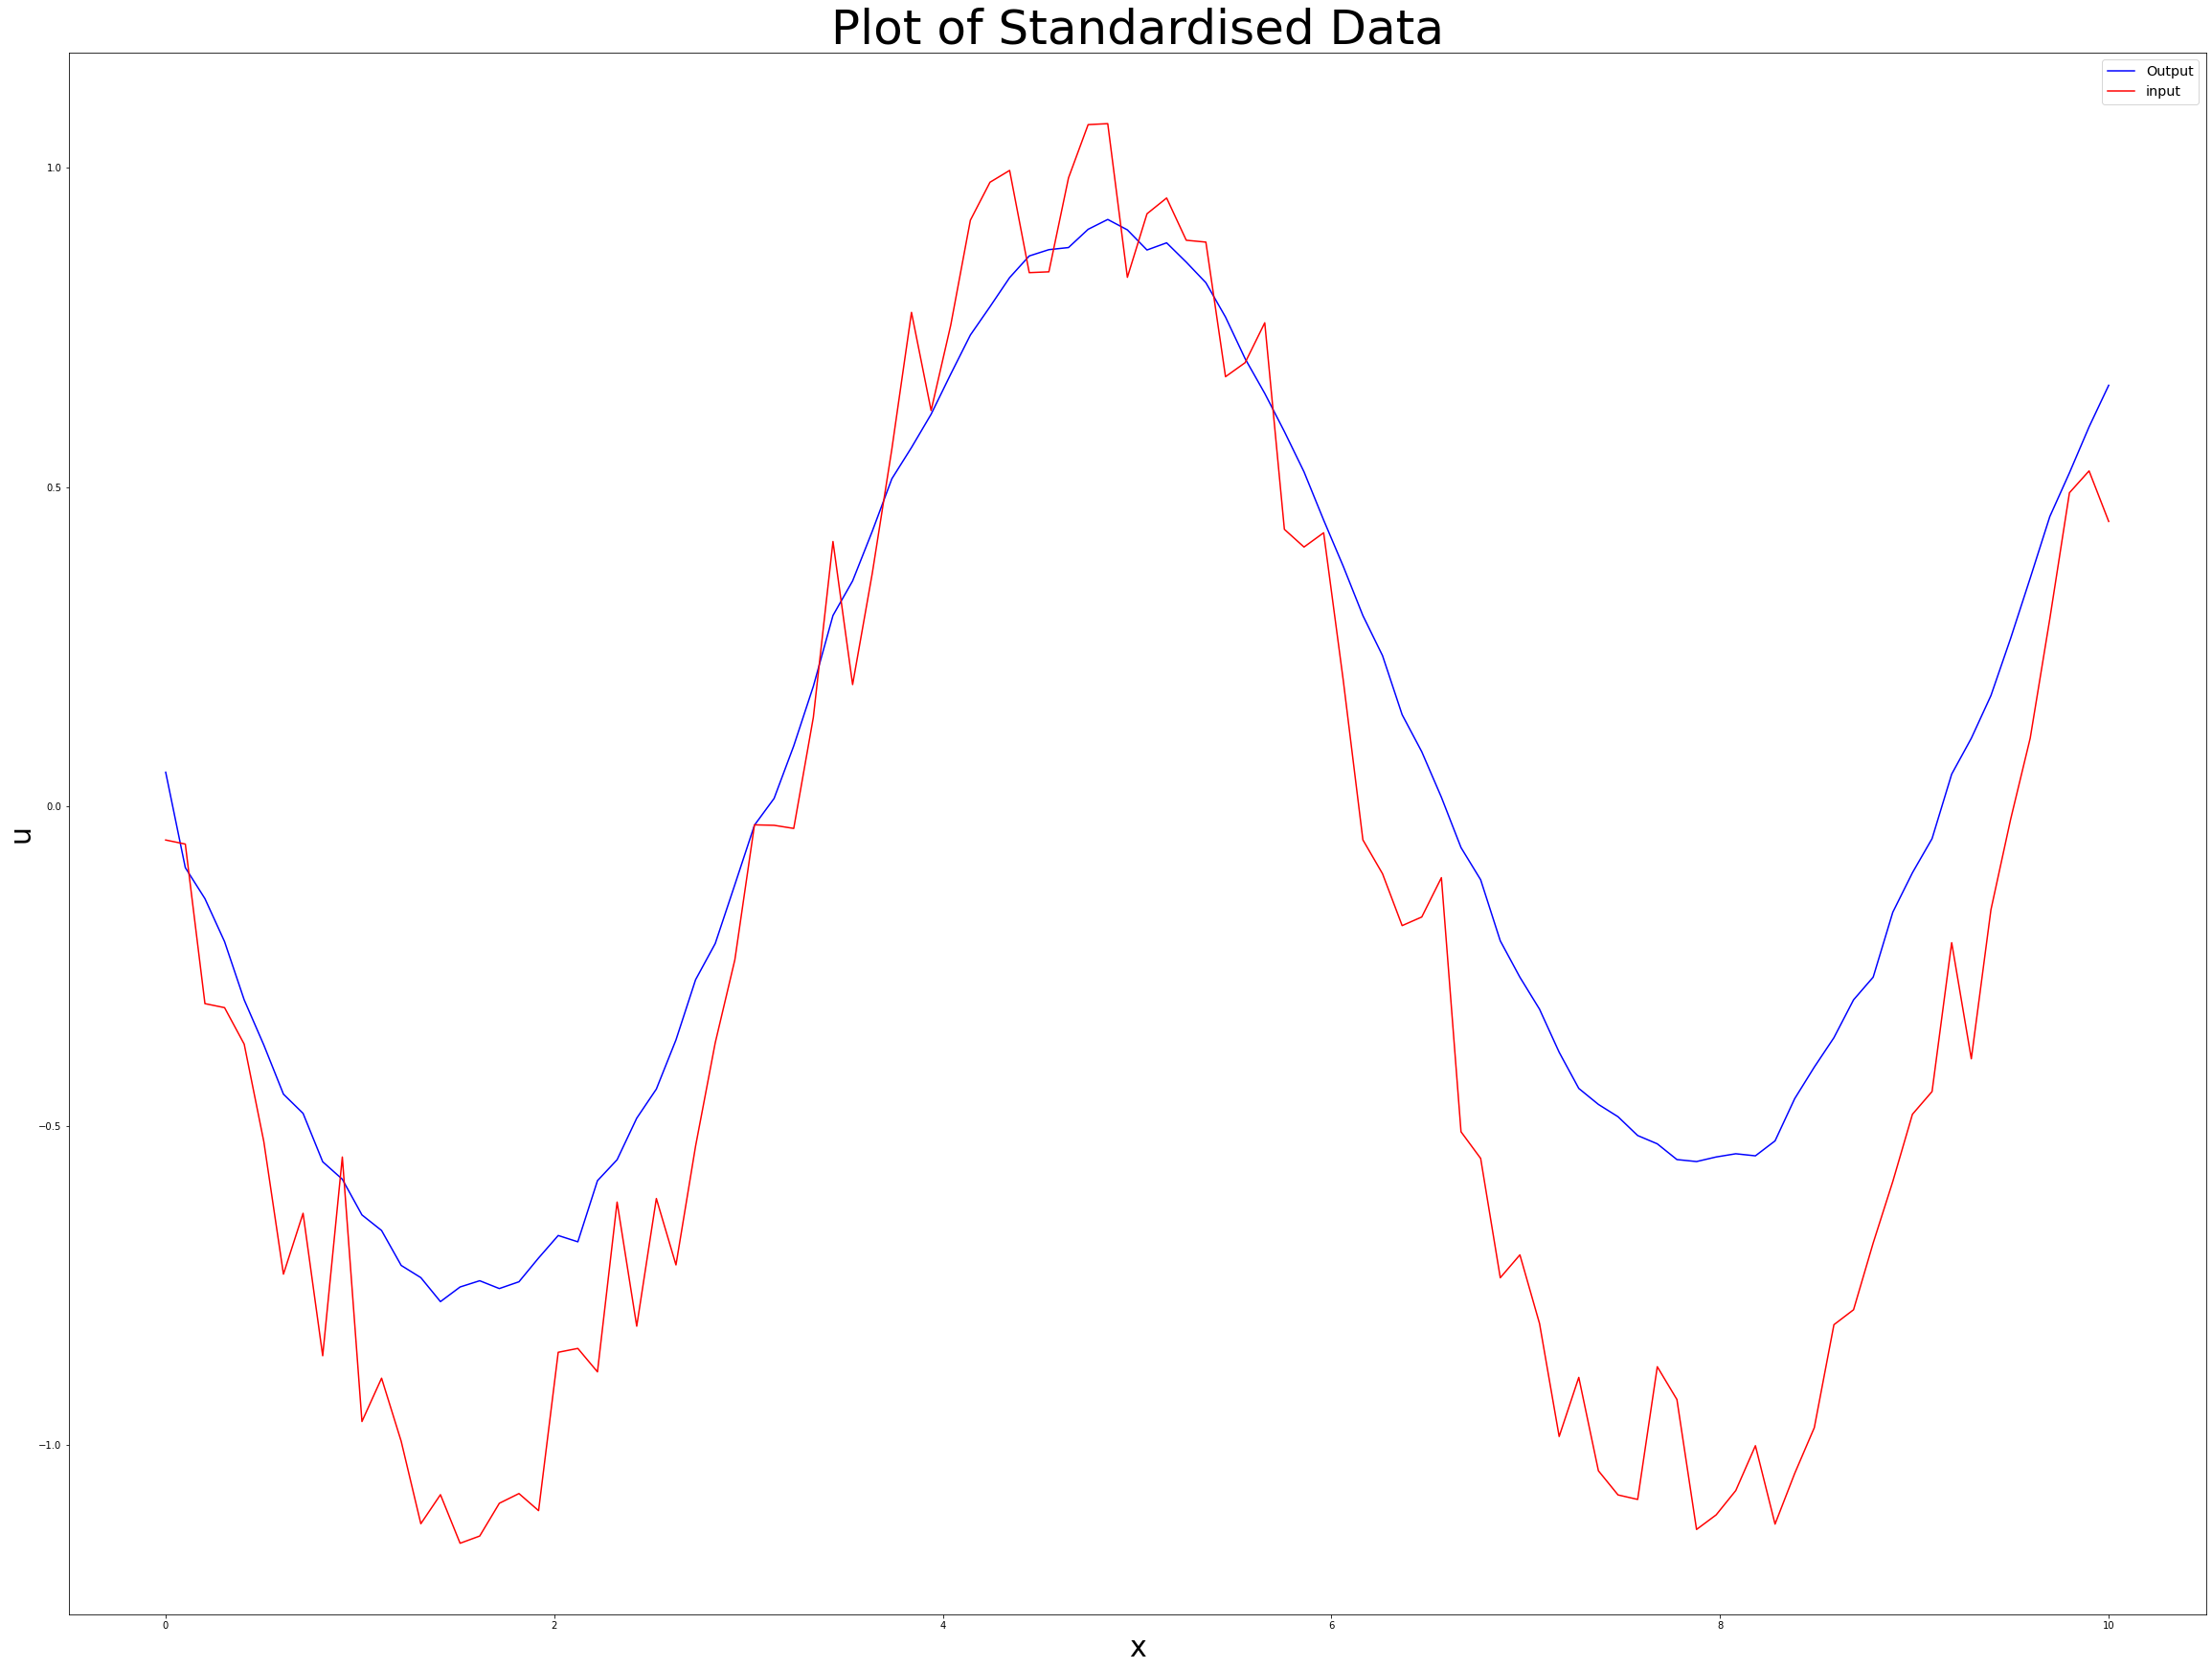

In [37]:
# This is a test of going from the PCA values back to the output.

'''
Question:
Calculating u via sum a*v[i] returns u that is too large.
'''
theta_index = 5

u = 0
#sum_a = 0
for i in range(3):
    a = torch.tensor( principal_componant[: , i] @ B)
    #sum_a = sum_a + a
    u = u + a[theta_index]*principal_componant[: , i]


f, ax = plt.subplots(1, 1, figsize=(40, 30))
ax.set_title('Plot of Standardised Data', fontsize = 50)
ax.set_xlabel('x', fontsize = 30)
ax.set_ylabel('u', fontsize = 30)

ax.plot(x , u/2200, 'b')
ax.plot(x , B[:,theta_index], 'r')
ax.legend(['Output', 'input'],fontsize='x-large')


tensor(107.3648, dtype=torch.float64)

In [17]:
sum(sum(principal_componant))

115.03919994710748

tensor([-529.8077, -567.3916, -527.6350, -464.0929, -396.8588, -327.2066,
        -253.9092, -185.1887, -120.3006,  -51.0741,   20.3149,   96.2053,
         162.9489,  232.6211,  308.8347,  374.6673,  442.3688,  525.2331,
         596.1012,  664.1698], dtype=torch.float64)